Симулятор содержит два класса: Agent и Simulator.

Для работы требуются матрицы с вероятностями переходов. Они используются в для населения симулятора агентами в классе Simulator.

Первый вариант - брать их из папки dynamic_matrix и количество агентов из stats для соответствующих типов агентов. Файлы в папках именуются как cluster_x, где x - имя типа юзера. 

Другой вариант - генерировать эти таблицы из данных. Это делается с помощью функции get_step_matrix() как описано ниже.

После заселения агентами среды прозводится симуляция движения агентов по экранам приложения. Время передвижения сэмплируется из экспоненциального распределения, вероятности берутся из матриц.

В результате получаем pd.DataFrame с траекториями всех агентов для каждого типа.

In [1]:
from retentioneering import init_config
from retentioneering import Simulator
import pandas as pd
import numpy as np
from psycopg2.extras import RealDictCursor
import psycopg2

### Читаем данные из базы

In [2]:
conn = psycopg2.connect(
    database='reboard-api',
    host='176.112.192.94',
    user='postgres',
    password='postgres',
    cursor_factory=RealDictCursor
)

def query(q):
    with conn:
        with conn.cursor() as cur:
            cur.execute(q)
            res = cur.fetchall()
    return pd.DataFrame(res)

data_full = query(f"""
    select
        ge_timestamp_event as event_timestamp,
        ge_session_id as user_pseudo_id,
        ge_event_name as event_name
    from pixel.game_event
    order by event_timestamp
""")

In [3]:
data_full.tail(10)

,event_timestamp,user_pseudo_id,event_name
4597,2019-08-15 13:10:58,1565874017671|1,game_board_click
4598,2019-08-15 13:11:00,1565874017671|1,game_board_click
4599,2019-08-15 13:11:02,1565874017671|1,game_board_click
4600,2019-08-15 13:11:05,1565874017671|1,game_board_click
4601,2019-08-15 13:11:06,1565874017671|1,game_board_click
4602,2019-08-15 13:11:12,1565874017671|1,game_board_click
4603,2019-08-15 13:11:14,1565874017671|1,game_board_click
4604,2019-08-15 13:11:15,1565874017671|1,game_board_click
4605,2019-08-15 13:11:16,1565874017671|1,game_board_click
4606,2019-08-15 13:11:16,1565874017671|1,aftergame_winfinish


In [5]:
## данные из csv
#data_full = pd.read_csv('datafull.csv', index_col=[0])
#data_full.retention.prepare()

## Конфигурируем retentioneering-параметры

In [4]:
init_config(
    experiments_folder='experiments', # folder for saving experiment results: graph visualization, heatmaps and etc.
    index_col='user_pseudo_id', # column by which we split users / sessions / whatever
    event_col='event_name', # column that describes event
    event_time_col='event_timestamp', # column that describes timestamp of event
    
    #let's pick positive event as sending the score (only available after game completed)
    positive_target_event='aftergame_send_score_confirm', # name of positive target event
    negative_target_event='lost', # name of negative target event
    
    pos_target_definition={ # how to define positive event, e.g. empty means that add passed for whom was not 'lost'
        
    },
    neg_target_definition={ # how to define negative event
        #emply means all that are not positive will be "lost"
    },
)

In [5]:
data_full = data_full.retention.prepare()

### Можно посмотреть, сколько шагов делали пользователи, дошедшие до целевого состояния

In [6]:
def get_trajectory_success_rate(data):
    return pd.concat([data.groupby('user_pseudo_id').apply(lambda x : x.size), data.groupby('user_pseudo_id').apply(lambda x : x[x['event_name'] == 'aftergame_send_score_confirm'].size)], axis=1).rename(columns={0:'trajectory length', 1:'successes'})

In [7]:
tr = get_trajectory_success_rate(data_full)
tr[tr['successes'] > 0]

,trajectory length,successes
user_pseudo_id,,
1561912242480|1,141,3
1562669991430|1,2451,60
1562793085561|1,3537,78
1563274196600|1,90,3
1563283879305|1,309,6
1563284880223|1,201,3
1563285078614|1,396,3
1563285810751|1,108,3
1563291600198|1,69,3


### а также посмотреть свои действия

In [8]:
my_id = "1563526370612|1"
data_full[data_full.user_pseudo_id == my_id]

,event_timestamp,user_pseudo_id,event_name
3492,2019-07-26 14:22:35,1563526370612|1,tech_screen_change_mainmenu
3494,2019-07-26 14:22:41,1563526370612|1,tech_screen_change_mainmenu
3495,2019-07-26 14:22:51,1563526370612|1,tech_screen_change_settings
3496,2019-07-26 14:22:53,1563526370612|1,link_retsite_click
3497,2019-07-26 14:22:56,1563526370612|1,tech_screen_change_mainmenu
3499,2019-07-26 14:23:45,1563526370612|1,tech_screen_change_mainmenu
4662,2019-07-26 14:23:46,1563526370612|1,lost


### Построим матрицу переходов

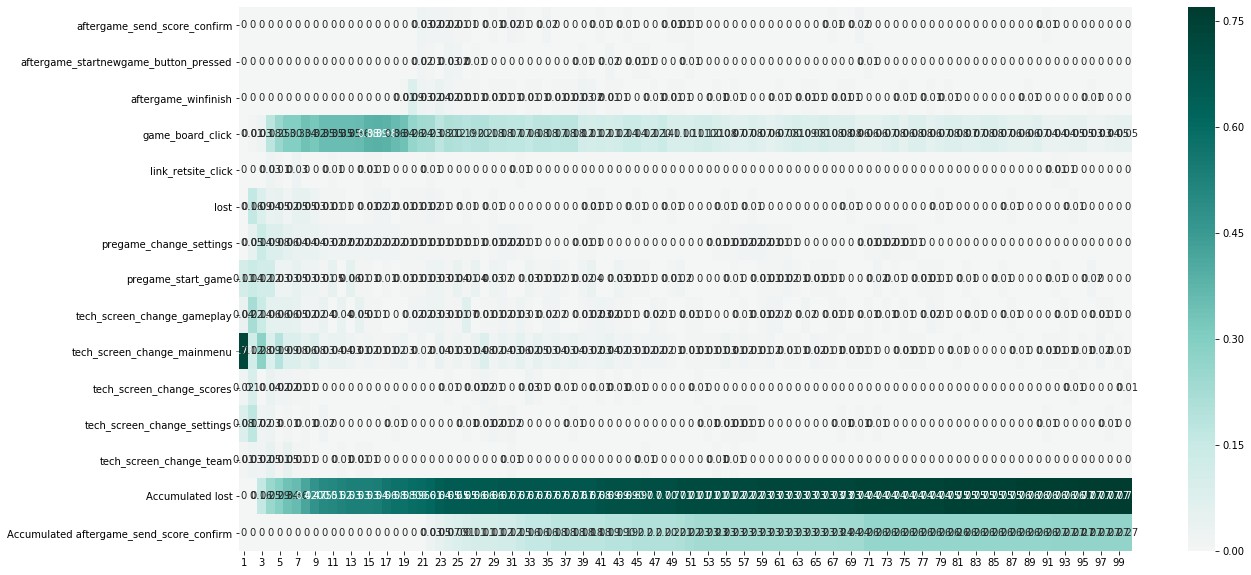

In [9]:
rebt = data_full.retention.get_step_matrix(dt_means=True, max_steps=100);
#dt_means добавляется в таблицу после отрисовки

### Можно указать параметр thr для фильтрации по значениям
При этом, строки Accumulated _smth_ и targets events не фильтруются и всегда включаются в таблицу

для фильтрации по target events можно передать параметр targets=False

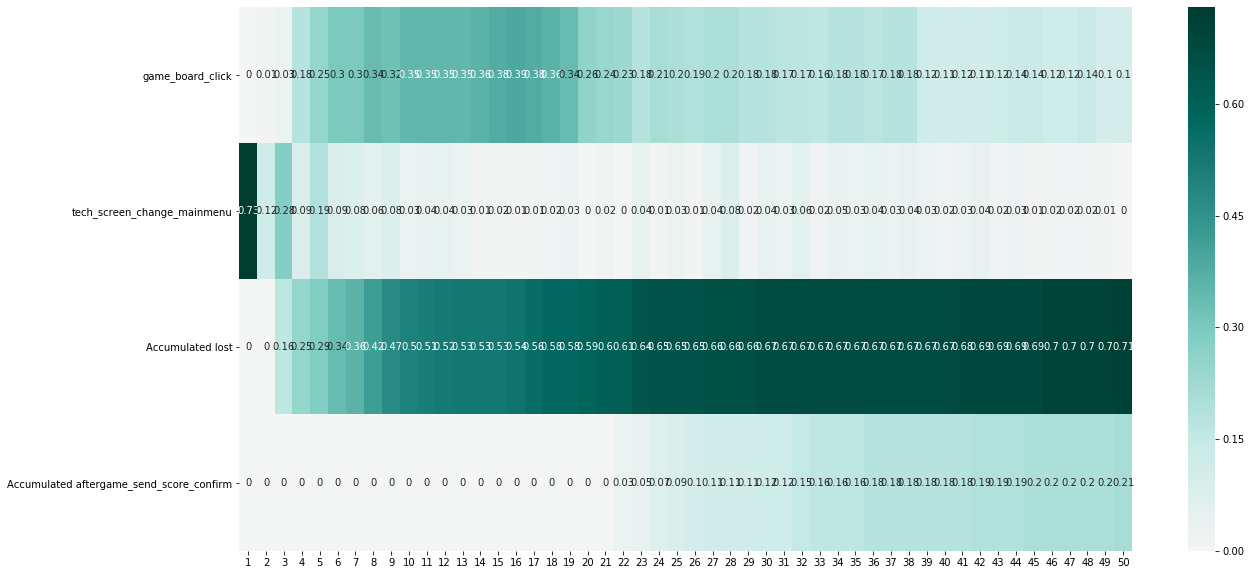

In [10]:
data_full.retention.get_step_matrix(dt_means=True, max_steps=50, thr=0.3, targets=False);

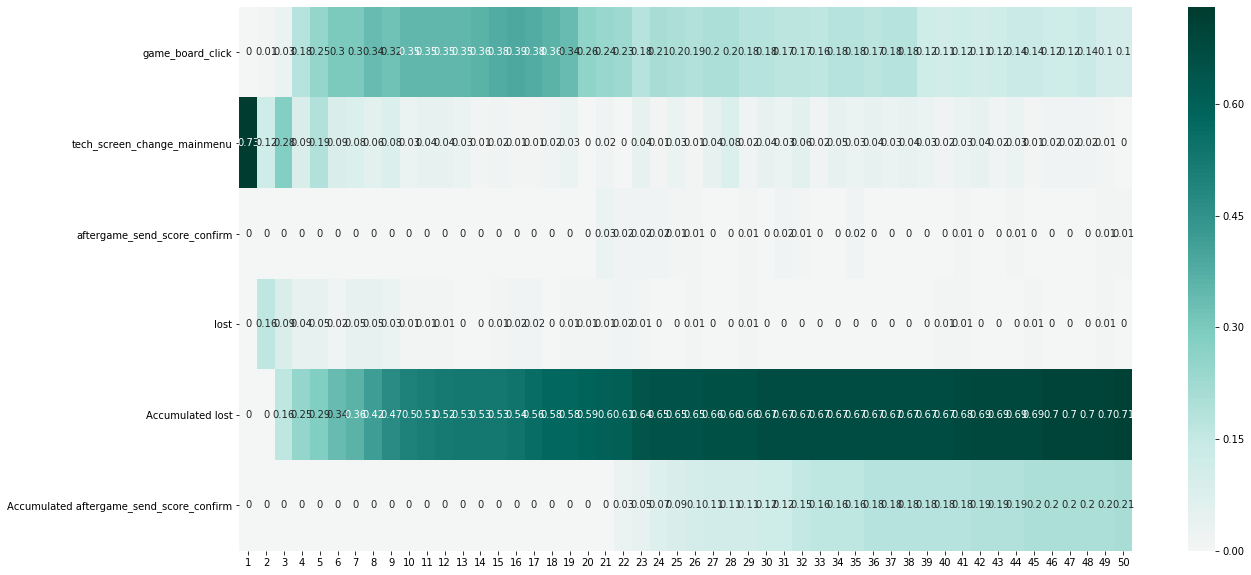

In [11]:
data_full.retention.get_step_matrix(dt_means=True, max_steps=50, thr=0.3);

Также действует на get_step_matrix_difference:

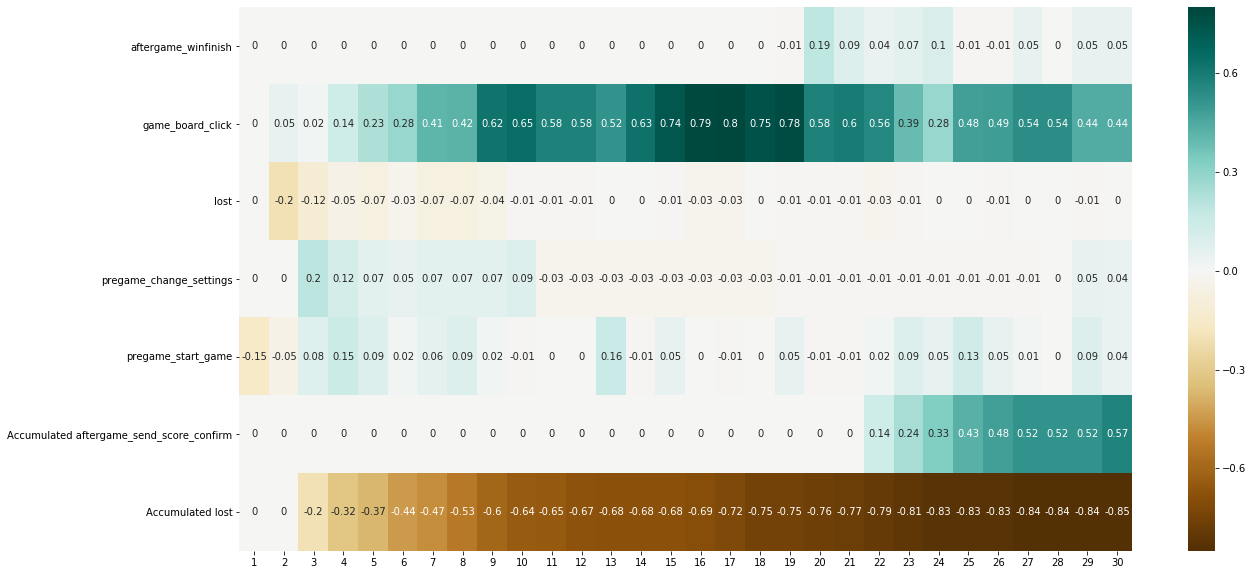

In [15]:
f = data_full.retention.create_filter(index_col='user_pseudo_id')
data_full.retention.get_step_matrix_difference(f, targets=False, thr=0.15);

### Можно указать параметр reverse для отображения траекторий с target events
reverse может быть 'pos', 'neg' или list с их комбинацией

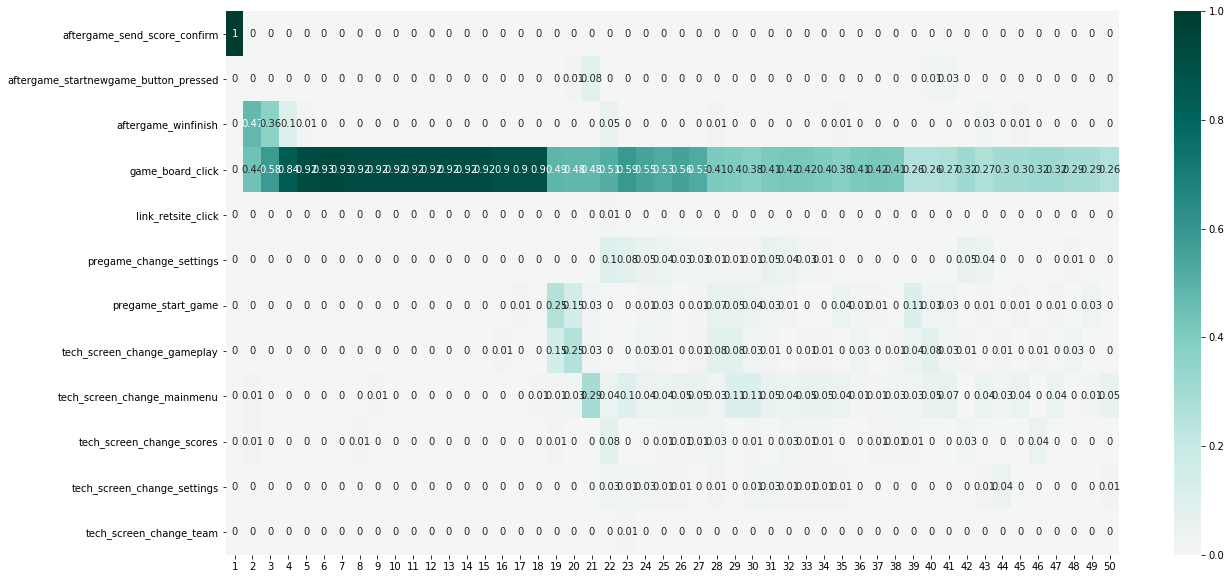

In [12]:
data_full.retention.get_step_matrix(dt_means=True, max_steps=50, reverse='pos');

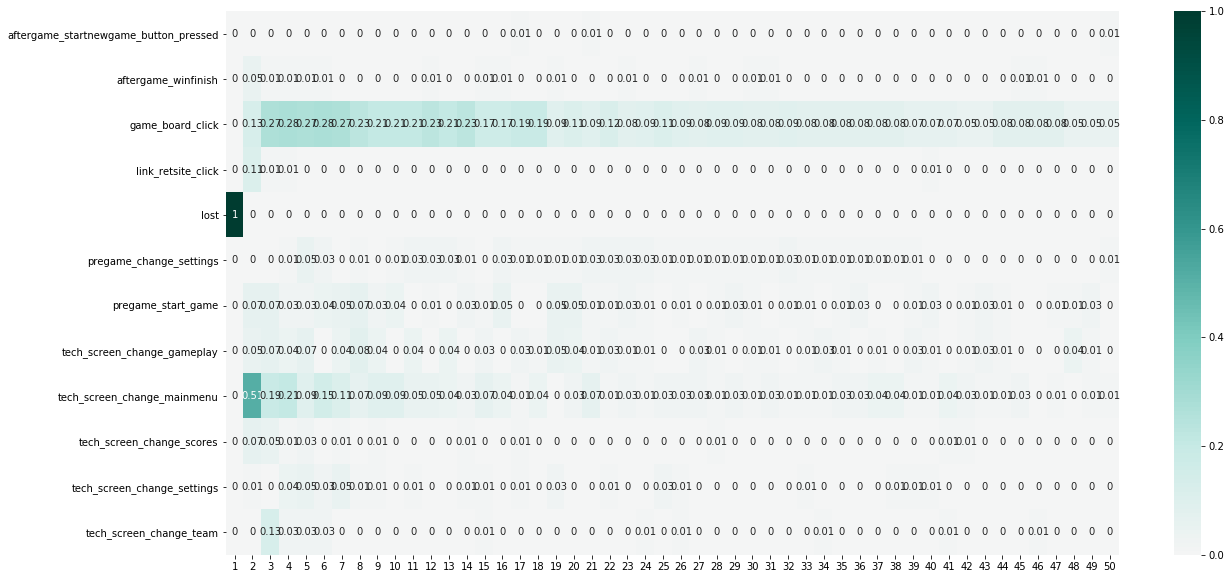

In [13]:
data_full.retention.get_step_matrix(dt_means=True, max_steps=50, reverse='neg');

### Передадим таблицу в симулятор, указав желаемое количество агентов (пользователей)

In [14]:
t = pd.datetime.now()
s = Simulator(tables=[rebt], num_pops=[500])
print(pd.datetime.now() - t, 'elapsed')

0:00:09.353019 elapsed


Чтобы загрузить матрицы из папки, можно передать имя данной папки (или путь к ней) в параметр **tables**

s = Simulator(tables='dynamic_matrix', num_pops=\[500\])

In [15]:
t = pd.datetime.now()
rebtdata = s.simulate()
rebtdata = rebtdata.sort_values('event_timestamp').retention.prepare()
print(pd.datetime.now() - t, 'elapsed')

0:00:32.758397 elapsed


### После симуляции получаем сгенерированные нами траектории пользователей
### К ним можно применять все функции retentioneering

In [16]:
rebtdata.retention.plot_graph((1200, 800), thresh=0.3)

C:\Anaconda\lib\site-packages\networkx\drawing\layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


In [17]:
(rebtdata['event_name'] == 'aftergame_send_score_confirm').sum()

165

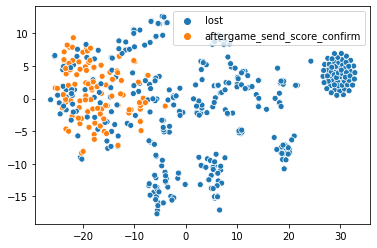

In [18]:
rebtdata.retention.learn_tsne(plot_type='targets');

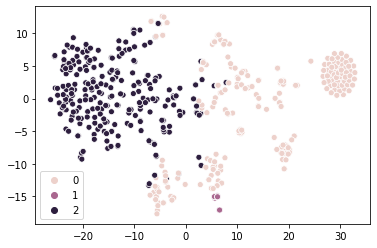

In [19]:
rebtdata.retention.learn_tsne(plot_type='clusters', refit_cluster=True, n_clusters=3);

In [20]:
rebtdata.retention.filter_cluster(1).retention.plot_graph((800, 500), thresh=0.1)

C:\Anaconda\lib\site-packages\networkx\drawing\layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


## Предиктор

In [21]:
model = rebtdata.retention.create_model()

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [22]:
features = rebtdata.retention.extract_features(ngram_range=(1,2))
target = features.index.isin(rebtdata.retention.get_positive_users())

In [23]:
model.permutation_importance(features, target, thresh=0.)


            ROC-AUC: 0.9030448717948718
            PR-AUC: 0.6293780938507838
            Accuracy: 0.834
            
